---

## Khmer News Classification with BERT Feature Extraction Based Approach
---

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import re
import numpy as np
import pandas as pd
import collections
import tensorflow as tf
import tensorflow_hub as hub

import warnings
warnings.filterwarnings('ignore')

### Load Pre-trained BERT module for khmer

In [19]:
!unzip "/content/drive/bert_module_khmer.zip" -d "./pretrained"

Archive:  /content/drive/My Drive/Colab Notebooks/Khmer Paper/bert_module_khmer.zip
   creating: ./pretrained/bert_module_khmer/
   creating: ./pretrained/bert_module_khmer/assets/
  inflating: ./pretrained/bert_module_khmer/assets/bert_config.json  
  inflating: ./pretrained/bert_module_khmer/assets/vocab_file_BERT_.txt  
  inflating: ./pretrained/bert_module_khmer/saved_model.pb  
  inflating: ./pretrained/bert_module_khmer/tfhub_module.pb  
   creating: ./pretrained/bert_module_khmer/variables/
  inflating: ./pretrained/bert_module_khmer/variables/variables.data-00000-of-00001  
  inflating: ./pretrained/bert_module_khmer/variables/variables.index  


### Load Data

In [10]:
data = pd.read_excel('/content/drive/news_classification_data_km.xlsx', encoding="UTF-8")
data.head()

,id,content,tokenized_content,category,category_en,text_prep
0,45541,រាជធានីភ្នំពេញ ៖នៅក្នុងពិភពសិល្បៈតារាសម្តែងមួយ...,រាជ ធានី ភ្នំ ពេញ ៖ នៅ ក្នុង ពិភព សិល្បៈ តារា ...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រាជ ធានី ភ្នំ ពេញ នៅ ក្នុង ពិភព សិល្បៈ តារា សម...
1,52071,រាជធានីភ្នំពេញ ៖ ក្រុមតន្ត្រីថ្មីមួយដែលមានឈ្មោ...,រាជ ធានី ភ្នំ ពេញ ៖ ក្រុម តន្ត្រី ថ្មី មួយ ដែល...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រាជ ធានី ភ្នំ ពេញ ក្រុម តន្ត្រី ថ្មី មួយ ដែល ម...
2,8906,រូបកាយយើងនេះញាំញីទៅដោយជំងឺដង្កាត់គ្រប់ប្រភេទ អ...,រូប កាយ យើង នេះ ញាំញី ទៅ ដោយ ជំងឺ ដង្កាត់ គ្រប...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រូប កាយ យើង នេះ ញាំញី ទៅ ដោយ ជំងឺ ដង្កាត់ គ្រប...
3,49697,រាជធានីភ្នំពេញ ៖ តារាសម្តែង និងជាអ្នកចម្រៀងវ័យ...,រាជ ធានី ភ្នំ ពេញ ៖ តារា សម្តែង និង ជា អ្នក ចម...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រាជ ធានី ភ្នំ ពេញ តារា សម្តែង និង ជា អ្នក ចម្រ...
4,46696,រាជធានីភ្នំពេញ ៖ អ្នកនាងឡាយ លក្ខិណា ក្រោយពេលវិ...,រាជ ធានី ភ្នំ ពេញ ៖ អ្នក នាង ឡាយ លក្ខិណា ក្រោយ...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រាជ ធានី ភ្នំ ពេញ អ្នក នាង ឡាយ លក្ខិណា ក្រោយ ព...


### Preprocessing

In [ ]:
data['text_prep'] = data['tokenized_content'].apply(lambda x: ' '.join(re.sub(r'[០១២៣៤៥៦៧៨៩។៕៖ៗ៘៙៚]+', ' ', x).strip().split()))
data.drop_duplicates(subset=['text_prep'], inplace=True)

In [12]:
data.shape

(7418, 7)

In [13]:
data['category_en'].value_counts()

international-news    999
national-news         999
research              999
health                999
arts-and-culture      998
service               994
sports-news           769
business              661
Name: category_en, dtype: int64

In [14]:
## Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label'] = le.fit_transform(data.loc[:, 'category_en'].copy().tolist())

In [15]:
data[['category_en', 'label']].drop_duplicates(subset=['category_en']).sort_values(by=['label']).reset_index(drop=True)

,category_en,label
0,arts-and-culture,0
1,business,1
2,health,2
3,international-news,3
4,national-news,4
5,research,5
6,service,6
7,sports-news,7


In [16]:
data.head()

,index,id,content,tokenized_content,category,category_en,text_prep,label
0,0,45541,រាជធានីភ្នំពេញ ៖នៅក្នុងពិភពសិល្បៈតារាសម្តែងមួយ...,រាជ ធានី ភ្នំ ពេញ ៖ នៅ ក្នុង ពិភព សិល្បៈ តារា ...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រាជ ធានី ភ្នំ ពេញ នៅ ក្នុង ពិភព សិល្បៈ តារា សម...,0
1,1,52071,រាជធានីភ្នំពេញ ៖ ក្រុមតន្ត្រីថ្មីមួយដែលមានឈ្មោ...,រាជ ធានី ភ្នំ ពេញ ៖ ក្រុម តន្ត្រី ថ្មី មួយ ដែល...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រាជ ធានី ភ្នំ ពេញ ក្រុម តន្ត្រី ថ្មី មួយ ដែល ម...,0
2,2,8906,រូបកាយយើងនេះញាំញីទៅដោយជំងឺដង្កាត់គ្រប់ប្រភេទ អ...,រូប កាយ យើង នេះ ញាំញី ទៅ ដោយ ជំងឺ ដង្កាត់ គ្រប...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រូប កាយ យើង នេះ ញាំញី ទៅ ដោយ ជំងឺ ដង្កាត់ គ្រប...,0
3,3,49697,រាជធានីភ្នំពេញ ៖ តារាសម្តែង និងជាអ្នកចម្រៀងវ័យ...,រាជ ធានី ភ្នំ ពេញ ៖ តារា សម្តែង និង ជា អ្នក ចម...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រាជ ធានី ភ្នំ ពេញ តារា សម្តែង និង ជា អ្នក ចម្រ...,0
4,4,46696,រាជធានីភ្នំពេញ ៖ អ្នកនាងឡាយ លក្ខិណា ក្រោយពេលវិ...,រាជ ធានី ភ្នំ ពេញ ៖ អ្នក នាង ឡាយ លក្ខិណា ក្រោយ...,សិល្បៈនិងវប្បធម៌,arts-and-culture,រាជ ធានី ភ្នំ ពេញ អ្នក នាង ឡាយ លក្ខិណា ក្រោយ ព...,0


### Data Partitioning

In [ ]:
X = data['text_prep']
y = data['label']

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1234, shuffle=True, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=1234, shuffle=True, stratify=y_val)

print("""Training shape: {}
Validation shape: {}
Testing shape: {}""".format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

Training shape: 5192
Validation shape: 1558
Testing shape: 668


### Tokenizer

In [20]:
def convert_to_unicode(text):
    """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
    if isinstance(text, str):
        return text
    elif isinstance(text, bytes):
        return text.decode("utf-8", "ignore")
    else:
        raise ValueError("Unsupported string type: %s" % (type(text)))

def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    index = 0
    with tf.gfile.GFile(vocab_file, "r") as reader:
        while True:
            token = convert_to_unicode(reader.readline())
            if not token:
                break
            token = token.strip()
            vocab[token] = index
            index += 1
    return vocab

def convert_by_vocab(vocab, items):
    """Converts a sequence of [tokens|ids] using the vocab."""
    output = []
    for item in items:
        try:
            output.append(vocab[item])
        except:
            pass
    return output

class FullTokenizer(object):
    """Runs end-to-end tokenziation."""

    def __init__(self, vocab_file, do_lower_case=False):
        self.vocab = load_vocab(vocab_file)

    def tokenize(self, text):
        """Runs basic whitespace cleaning and splitting on a piece of text."""
        text = text.strip()
        if not text:
            return []
        tokens = text.split()
        return tokens

    def convert_tokens_to_ids(self, tokens):
        return convert_by_vocab(self.vocab, tokens)

In [21]:
vocab_path = '/content/pretrained/bert_module_khmer/assets/vocab_file_BERT_.txt'
tokenizer = FullTokenizer(vocab_file=vocab_path, do_lower_case=True)

### BERT Input Generator

In [22]:
def convert_sentence_to_features(sentence, tokenizer, max_seq_len):
    tokens = ['[CLS]']
    tokens.extend(tokenizer.tokenize(sentence))
    if len(tokens) > max_seq_len-1:
        tokens = tokens[:max_seq_len-1]
    tokens.append('[SEP]')
    
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)
    segment_ids = [0] * len(input_ids)
    
    zero_padding = [0] * (max_seq_len-len(input_ids))

    input_ids.extend(zero_padding)
    input_mask.extend(zero_padding)
    segment_ids.extend(zero_padding)
    
    return input_ids, input_mask, segment_ids

def convert_sentences_to_features(sentences, tokenizer, max_seq_len=64):
    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    
    for sentence in sentences:
        input_ids, input_mask, segment_ids = convert_sentence_to_features(sentence, tokenizer, max_seq_len)
        all_input_ids.append(input_ids)
        all_input_mask.append(input_mask)
        all_segment_ids.append(segment_ids)
    
    return all_input_ids, all_input_mask, all_segment_ids

### Load BERT Pre-trained Module

In [23]:
BERT_URL = '/content/pretrained/bert_module_khmer'
module = hub.Module(BERT_URL)

### Feature Extraction

In [24]:
def creat_BERT_embeddings(sentences):
    """Create BERT Embeddings from tokenized Text

    Argument: A list of Sentences
    Return: A numpy array of BERT embeddings
    """
    input_ids_vals, input_mask_vals, segment_ids_vals = convert_sentences_to_features(sentences, tokenizer, 64)

    ### SIGNATURE
    input_ids = tf.placeholder(dtype=tf.int32, shape=[None, None])
    input_mask = tf.placeholder(dtype=tf.int32, shape=[None, None])
    segment_ids = tf.placeholder(dtype=tf.int32, shape=[None, None])

    bert_inputs = dict(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids)
    
    bert_outputs = module(bert_inputs, signature="tokens", as_dict=True)

    pooled_embeddings = []
    # sequence_embeddings = []

    ### CREAT BATCH PROCESS
    input_ids_tensors = tf.compat.v1.data.Dataset.from_tensor_slices(input_ids_vals)
    input_mask_tensors = tf.compat.v1.data.Dataset.from_tensor_slices(input_mask_vals)
    segment_ids_tensors = tf.compat.v1.data.Dataset.from_tensor_slices(segment_ids_vals)
    dcombined = tf.compat.v1.data.Dataset.zip((input_ids_tensors, input_mask_tensors, segment_ids_tensors)).batch(512)

    iterator = tf.compat.v1.data.make_one_shot_iterator(dcombined)
    next_ele = iterator.get_next()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        try:
            while True:
                inputs = sess.run(next_ele)

                input_ids_vals = inputs[0]
                input_mask_vals = inputs[1]
                segment_ids_vals = inputs[2]
                out = sess.run(bert_outputs, feed_dict={input_ids: input_ids_vals,
                                                        input_mask: input_mask_vals, 
                                                        segment_ids: segment_ids_vals})

                pooled_embeddings.extend(out['pooled_output'].tolist())
                # sequence_embeddings.extend(out['sequence_output'].tolist())
        except tf.errors.OutOfRangeError:
            pass
    return np.array(pooled_embeddings)

In [19]:
### export embeddings for tSNE analysis
# X_embeddings = pd.DataFrame(creat_BERT_embeddings(X)).add_prefix('Col_')
# pd.concat([X_embeddings, y], axis=1).to_csv("news_data_embeddings.csv", encoding='utf-8', index=False)
# !zip -r "/content/drive/news_data_embeddings.zip" /content/news_data_embeddings.csv

In [22]:
%%time
X_train_embeddings = pd.DataFrame(creat_BERT_embeddings(X_train)).add_prefix('Col_')
X_val_embeddings = pd.DataFrame(creat_BERT_embeddings(X_val)).add_prefix('Col_')
X_test_embeddings = pd.DataFrame(creat_BERT_embeddings(X_test)).add_prefix('Col_')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
CPU times: user 22.8 s, sys: 9.68 s, total: 32.4 s
Wall time: 38.7 s


### Model Architecture

In [5]:
import random as rn

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import History
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [25]:
from keras.utils import to_categorical

y_train_k = to_categorical(y_train, num_classes=8)
y_val_k = to_categorical(y_val, num_classes=8)
y_test_k = to_categorical(y_test, num_classes=8)

In [48]:
np.random.seed(2)
rn.seed(3)
history = History()

model = Sequential()
model.add(Dense(units = 2048, activation = "tanh", input_dim=768))
model.add(Dropout(0.1))
model.add(Dense(units = 1024, activation = "tanh"))
model.add(Dropout(0.1))
model.add(Dense(units = 512, activation = "tanh"))
model.add(Dropout(0.1))
model.add(Dense(units = 256, activation = "tanh"))
model.add(Dropout(0.1))
model.add(Dense(units = 128, activation = "tanh"))
model.add(Dropout(0.1))
model.add(Dense(units = 8, activation = "softmax"))

model.compile(optimizer=Adam(0.001), loss="categorical_crossentropy", metrics=['accuracy'])

model.fit(np.array(X_train_embeddings), np.array(y_train_k), 
          validation_data=(np.array(X_val_embeddings), np.array(y_val_k)), 
          epochs=17, 
          batch_size=2000, 
          shuffle=True, 
          callbacks=[history], 
          verbose=True)

Train on 5192 samples, validate on 1558 samples
Epoch 1/17
5192/5192 [==============================] - 1s 217us/step - loss: 2.4211 - accuracy: 0.2223 - val_loss: 2.1180 - val_accuracy: 0.3427
Epoch 2/17
5192/5192 [==============================] - 0s 18us/step - loss: 1.8854 - accuracy: 0.3727 - val_loss: 1.4123 - val_accuracy: 0.5071
Epoch 3/17
5192/5192 [==============================] - 0s 17us/step - loss: 1.2936 - accuracy: 0.5535 - val_loss: 0.9491 - val_accuracy: 0.6900
Epoch 4/17
5192/5192 [==============================] - 0s 18us/step - loss: 0.8731 - accuracy: 0.7198 - val_loss: 0.7002 - val_accuracy: 0.7580
Epoch 5/17
5192/5192 [==============================] - 0s 19us/step - loss: 0.6948 - accuracy: 0.7660 - val_loss: 0.6238 - val_accuracy: 0.7997
Epoch 6/17
5192/5192 [==============================] - 0s 18us/step - loss: 0.6162 - accuracy: 0.7912 - val_loss: 0.5897 - val_accuracy: 0.8087
Epoch 7/17
5192/5192 [==============================] - 0s 18us/step - loss: 0.56

In [25]:
# for learning curve
his_train_loss = history.history['loss']
his_val_loss = history.history['val_loss']

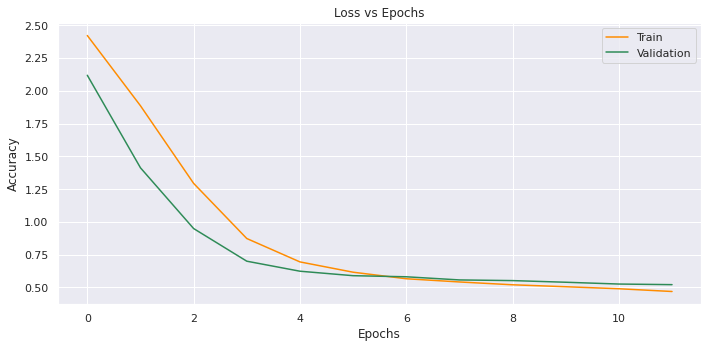

In [87]:
## Plot learning curve
import matplotlib.pyplot as plt
sns.set()
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(his_train_loss,'darkorange')
plt.plot(his_val_loss, 'seagreen')

plt.title("Loss vs Epochs", fontdict={'fontsize': 12})
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
# plt.savefig("news_loss_vs_epochs_BERT_feature_based.jpg", dpi=300, bbox_inches='tight')
plt.show()

### Prediction

In [53]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [54]:
y_pred = model.predict(np.array(X_test_embeddings))
ac = accuracy_score(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))
print("Test Accuracy:", round(ac, 2))

Test Accuracy: 0.82


In [ ]:
## generate confusion matrix
cm = confusion_matrix(y_test_k.argmax(axis=1), y_pred.argmax(axis=1))

In [56]:
print("Confusion Matrix: ")
p = pd.DataFrame(cm, 
                 index=[['Actual']*8,list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7]))], 
                 columns=[['Predicted']*8,list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7]))])

p.style.set_properties(**{'background-color': 'skyblue', 
                          'color': 'black'})

Confusion Matrix: 


In [ ]:
p = pd.DataFrame(cm, 
                 index=list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7])), 
                 columns=list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7])))

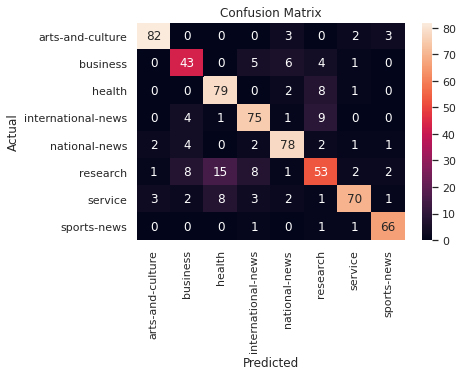

In [61]:
## Confusion Matrix in Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
# plt.figure(figsize=(12, 8))
sns.set()
f = sns.heatmap(p, annot=True)
plt.title("Confusion Matrix", fontdict={'fontsize': 12})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

f.get_figure().savefig("news_confusion_matrix_BERT_feature_based.jpg", dpi=300, bbox_inches='tight')

In [62]:
## Classification Report
target_names = list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7]))
print(classification_report(y_test_k.argmax(axis=1), y_pred.argmax(axis=1), target_names = target_names))

                    precision    recall  f1-score   support

  arts-and-culture       0.93      0.91      0.92        90
          business       0.70      0.73      0.72        59
            health       0.77      0.88      0.82        90
international-news       0.80      0.83      0.82        90
     national-news       0.84      0.87      0.85        90
          research       0.68      0.59      0.63        90
           service       0.90      0.78      0.83        90
       sports-news       0.90      0.96      0.93        69

          accuracy                           0.82       668
         macro avg       0.82      0.82      0.81       668
      weighted avg       0.82      0.82      0.82       668

